# Step 1: Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install openpyxl
#!pip install --upgrade pip

# Step 2: Loading Data

In [2]:
# Load the Accessories sheet from the Excel file
outdoor_data = pd.read_excel('Outdoor.xlsx', sheet_name="Outdoor")

# Display the first few rows to inspect the data
outdoor_data.head()

,Customer Name,Reporting Business Type,Collective Class,Series No,Item SKU,Item Description,Colors,Series Color,Item Grouping,AFI Sales Category,Import/Domestic Code,Market Introduced At,Parent Style Description,Warehouse,Order Quantity,FiscalMonthLastDate,Status
0,Customer 1,US,OUTDOOR,P312-049,P312-049,CHAIRS W/TABLE SET (3/CN),Gray,Multi,Outdoor Dining,Sig. Motion Outdoor,I,QTR 4 2021,Casual,1,2.0,2023-04-29,Invoiced
1,Customer 3,US,OUTDOOR,P459,P459-877,CORNER WITH CUSHION (2/CN),Gray,Gray,Outdoor Seating,Sig. Motion Outdoor,I,QTR 2 2021,Casual,17,2.0,2023-05-27,Invoiced
2,Customer 4,e-Commerce,OUTDOOR,P730,P730-615,ROUND DINING TABLE W/UMB OPT,Brown,Brown,Outdoor Dining,Sig. Motion Outdoor,I,QTR 2 2021,Casual,1,3.0,2024-06-29,Invoiced
3,Customer 5,US,OUTDOOR,P220,P220-115,DINING TABLE SET (3/CN),Brown/Black,Brown/Black,Outdoor Dining,Sig. Motion Outdoor,I,Las Vegas July 2020,Casual,5,9.0,2022-03-26,Invoiced
4,Customer 6,US,OUTDOOR,P334,P334-081,SOFA/CHAIRS/TABLE SET (4/CN),Gray,Gray,Outdoor Seating,Sig. Motion Outdoor,I,Las Vegas July 2019,Contemporary,1,2.0,2022-07-23,Invoiced


In [3]:
#Step 1: showing qantity of rows and columns of data
print(f"\033[1m\nThere are {outdoor_data.shape[0]} rows and {outdoor_data.shape[1]} columns in the data\033[0m")

#Step 2: define function to inspect data types and nulls
def inspect(df):
    column_summary = []
    for col in df.columns:
        column_info = {
            "Column": col,
            "Data Type": df[col].dtype,
            "Unique Values": df[col].nunique(),
            "Null Values":df[col].isna().sum()
        }
        column_summary.append(column_info)
    
    return pd.DataFrame(column_summary)
inspect(outdoor_data)


There are 335740 rows and 17 columns in the data


,Column,Data Type,Unique Values,Null Values
0,Customer Name,object,4573,1
1,Reporting Business Type,object,3,0
2,Collective Class,object,1,1
3,Series No,object,235,1
4,Item SKU,object,699,1
5,Item Description,object,123,1
6,Colors,object,58,1
7,Series Color,object,40,1
8,Item Grouping,object,4,1
9,AFI Sales Category,object,2,1


# Step 3: EDA

In [60]:
df = outdoor_data[[
    "FiscalMonthLastDate", "Item Grouping", "Series No", "Item SKU", "Order Quantity"
]].copy().dropna()

In [61]:
# **Step 1: Rename Columns First to Remove Spaces**
df.columns = [col.replace(" ", "_") for col in df.columns]

# Convert FiscalMonthLastDate to datetime format
df["FiscalMonthLastDate"] = pd.to_datetime(df["FiscalMonthLastDate"])

# **Step 2: Aggregate Data for Hierarchical Structure**
df_agg = df.groupby(["FiscalMonthLastDate", "Item_Grouping", "Series_No", "Item_SKU"])["Order_Quantity"].sum().reset_index()

# 🟢 **Step 3: Convert to Wide Format for Forecasting**
df_wide = df_agg.pivot_table(
    index="FiscalMonthLastDate",
    columns=["Item_Grouping", "Series_No", "Item_SKU"],
    values="Order_Quantity",
    fill_value=0
)

# 🟢 **Step 4: Compute Hierarchical Aggregations**
# Step 4.1: Compute **Total (Overall Sum)**
df_total = df_wide.sum(axis=1).to_frame(name=("Total", "", ""))

# Step 4.2: Compute **Item Grouping Level Totals**
df_item_grouping = df_wide.groupby(level=0, axis=1).sum()
df_item_grouping.columns = pd.MultiIndex.from_tuples([(col, "", "") for col in df_item_grouping.columns])

# Step 4.3: Compute **Series No Level Totals**
df_series_no = df_wide.groupby(level=[0, 1], axis=1).sum()
df_series_no.columns = pd.MultiIndex.from_tuples([(col[0], col[1], "") for col in df_series_no.columns])

# 🟢 **Step 5: Merge All Hierarchical Levels**
df_hierarchical_outdoor = pd.concat([df_total, df_item_grouping, df_series_no, df_wide], axis=1)

# 🟢 **Step 6: Sort Columns Hierarchically**
ordered_columns = sorted(
    df_hierarchical_outdoor.columns, 
    key=lambda x: (
        0 if x[0] == "Total" else  # Total first
        1 if x[1] == "" else  # Item Grouping next
        2 if x[2] == "" else  # Series No next
        3,  # Item SKU last
        x[0], x[1], x[2]  # Maintain group order
    )
)
df_hierarchical_outdoor = df_hierarchical_outdoor[ordered_columns]  # Apply sorting

# 🟢 **Step 7: Flatten MultiIndex Columns (No Spaces)**
df_hierarchical_outdoor.columns = [
    "_".join(filter(None, col)).replace(" ", "-") for col in df_hierarchical_outdoor.columns
]

df_hierarchical_outdoor

,Total,Outdoor-Accessories,Outdoor-Dining,Outdoor-Fire-Pit-Chat,Outdoor-Seating,Outdoor-Accessories_P000,Outdoor-Accessories_P018,Outdoor-Accessories_P030,Outdoor-Accessories_PA160,Outdoor-Accessories_PA187,...,Outdoor-Seating_P804-877_P804-877,Outdoor-Seating_P805_P805-701,Outdoor-Seating_P805_P805-702,Outdoor-Seating_P805_P805-814,Outdoor-Seating_P805_P805-820,Outdoor-Seating_P805_P805-835,Outdoor-Seating_P805_P805-838,Outdoor-Seating_P814_P814-701,Outdoor-Seating_P814_P814-820,Outdoor-Seating_P814_P814-838
FiscalMonthLastDate,,,,,,,,,,,,,,,,,,,,,
2022-01-22,90997,1392,23258,2449,63898,9,2,955,0,0,...,305,794,833,53,120,60,74,0,0,0
2022-02-19,84662,898,18934,2871,61959,16,2,573,0,0,...,777,473,650,15,150,0,0,0,0,0
2022-03-26,122056,1181,26256,3949,90670,6,0,325,0,0,...,437,811,836,0,113,93,71,0,0,0
2022-04-23,102546,1416,20799,3084,77247,0,0,401,0,0,...,370,689,679,0,0,0,0,0,0,0
2022-05-21,72504,1208,14823,2324,54149,0,0,148,0,0,...,314,493,716,0,0,0,0,0,0,0
2022-06-25,87400,1502,16743,2241,66914,0,0,341,0,0,...,348,523,799,0,0,0,0,0,0,0
2022-07-23,46117,887,8755,1092,35383,0,0,132,0,0,...,140,536,490,0,0,0,0,0,0,0
2022-08-20,36747,720,5998,842,29187,0,0,64,0,0,...,170,632,531,0,0,0,0,0,0,0
2022-09-24,39362,909,6729,1150,30574,0,0,87,0,0,...,225,550,1179,0,0,0,0,0,0,0


**Issue Identification:**
1. Due to the 4-4-5 week format, there are duplicated records in April 2023 (4/2023) and July 2023 (7/2023).
1. This results in the absence of March 2023 and June 2023 in the dataset.

**Adjustment Approach:**

1. Identify the first recorded date in April 2023 and July 2023.
1. Replace these dates with the last Saturday of March 2023 and June 2023, respectively, to maintain the correct sequence.

In [62]:
# Replace specific dates in the index:
df_hierarchical_outdoor.index = df_hierarchical_outdoor.index.to_series().replace({
    pd.Timestamp("2023-04-01"): pd.Timestamp("2023-03-25"),
    pd.Timestamp("2023-07-01"): pd.Timestamp("2023-06-24")
})

# 🟢 **Step 8: Save & Display Data**
df_hierarchical_outdoor.to_csv("Ashley_Outdoor_Hierarchical.csv", index=True)

# EDA

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

# Part B: Identify Stopped Production by Series/SKU
# =============================================================================
# We'll work from the adjusted file.
df_adj = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Set the date as the index for time‐series operations.
df_adj = df_adj.set_index("FiscalMonthLastDate").sort_index()

## Stop produced SKUs

In [64]:
# Identify SKU-level columns:
# By convention, SKU-level columns contain exactly two underscores (e.g. "Outdoor-Seating_P805_P805-83").
sku_columns = [col for col in df_adj.columns if col != "Total" and col.count("_") == 2]

stopped_list = []
# Loop through each SKU-level column and compute "stopped" flags.
for col in sku_columns:
    series = df_adj[col]
    # Proceed only if there are at least 12 observations.
    if len(series) < 12:
        continue
    last12 = series.iloc[-12:]
    last6  = series.iloc[-6:]
    stopped_12 = (last12 == 0).all()  # True if all last 12 months are zero
    stopped_6  = (last6  == 0).all()  # True if all last 6 months are zero
    stopped_list.append({
        "SKU": col,
        "Stopped_Last12": stopped_12,
        "Stopped_Last6": stopped_6
    })

stopped_df_adj = pd.DataFrame(stopped_list)

# Summaries
num_stopped_last12 = stopped_df_adj["Stopped_Last12"].sum()
num_stopped_last6  = stopped_df_adj["Stopped_Last6"].sum()

print("Summary for SKU Level:")
print(f"  Stopped in Last 12 Months: {num_stopped_last12} out of {len(stopped_df_adj)}")
print(f"  Stopped in Last 6 Months:  {num_stopped_last6} out of {len(stopped_df_adj)}\n")

# Display the names of the stopped SKUs for each condition
print("SKU-Level Products Stopped in Last 12 Months:")
for sku in stopped_df_adj[stopped_df_adj["Stopped_Last12"] == True]["SKU"]:
    print("  ", sku)

print("\nSKU-Level Products Stopped in Last 6 Months:")
for sku in stopped_df_adj[stopped_df_adj["Stopped_Last6"] == True]["SKU"]:
    print("  ", sku)

# Save the results to a CSV file.
stopped_df_adj.to_csv("Stopped_Production_SKU_Results.csv", index=False)
print("\nResults saved to 'Stopped_Production_SKU_Results.csv'")


Summary for SKU Level:
  Stopped in Last 12 Months: 86 out of 699
  Stopped in Last 6 Months:  160 out of 699

SKU-Level Products Stopped in Last 12 Months:
   Outdoor-Accessories_P000_P000-987
   Outdoor-Accessories_P000_P000-996B
   Outdoor-Accessories_P018_P018-991
   Outdoor-Accessories_PA187_PA187-002
   Outdoor-Accessories_PA226_PA226-002
   Outdoor-Accessories_PA309_PA309-002
   Outdoor-Accessories_PA313_PA313-002
   Outdoor-Accessories_PA313_PA313-003
   Outdoor-Accessories_PA320_PA320-001
   Outdoor-Accessories_PA320_PA320-002
   Outdoor-Accessories_PA320_PA320-012
   Outdoor-Accessories_PA320_PA320-022
   Outdoor-Accessories_PA345_PA345-002
   Outdoor-Accessories_PA345_PA345-003
   Outdoor-Accessories_PA349_PA349-011
   Outdoor-Accessories_PA360_PA360-001
   Outdoor-Accessories_PA390_PA390-011
   Outdoor-Accessories_PA390_PA390-032
   Outdoor-Accessories_PA414_PA414-002
   Outdoor-Accessories_PA414_PA414-003
   Outdoor-Accessories_PA440_PA440-002
   Outdoor-Accessories_PA440_

In [65]:
#uncomment to verify the data frame above
#df_adj['Outdoor-Fire-Pit-Chat_P011-776_P011-776'].tail(12)

## Decomposition

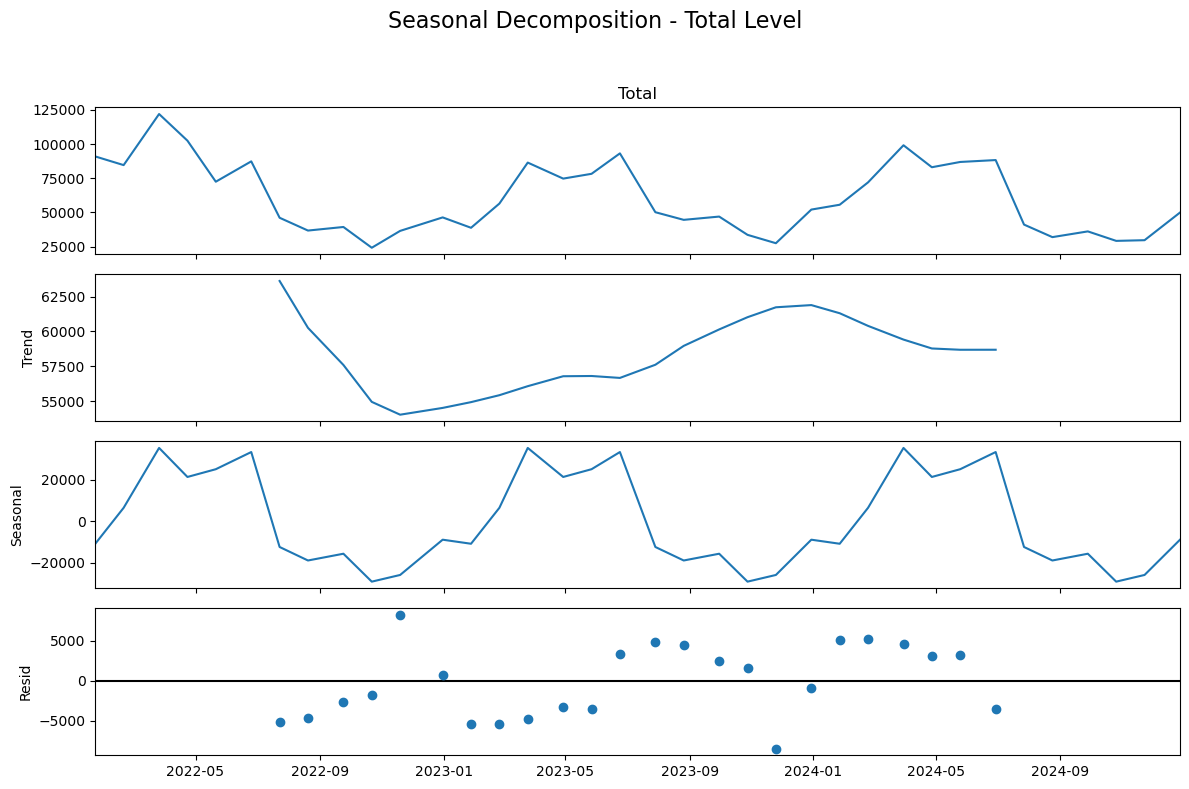

In [66]:
# =============================================================================
# Part C: Seasonal Decomposition
# =============================================================================
# (1) Decomposition for Total Level:
if "Total" in df_adj.columns:
    total_series = df_adj["Total"]
    try:
        decomp_total = seasonal_decompose(total_series, model="additive", period=12)
        fig_total = decomp_total.plot()
        fig_total.set_size_inches(12, 8)
        plt.suptitle("Seasonal Decomposition - Total Level", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    except Exception as e:
        print(f"Decomposition failed for Total: {e}")
else:
    print("No 'Total' column found for decomposition.")


Decomposition for Item Grouping Level:


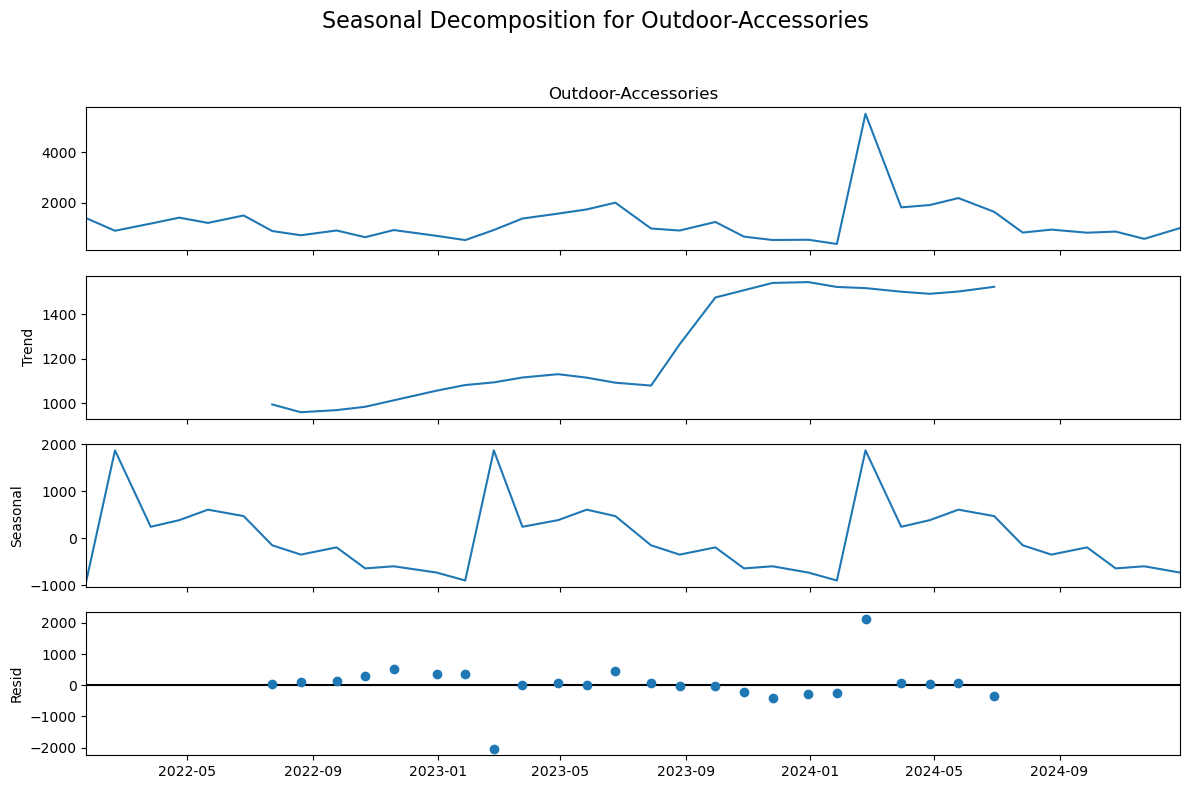

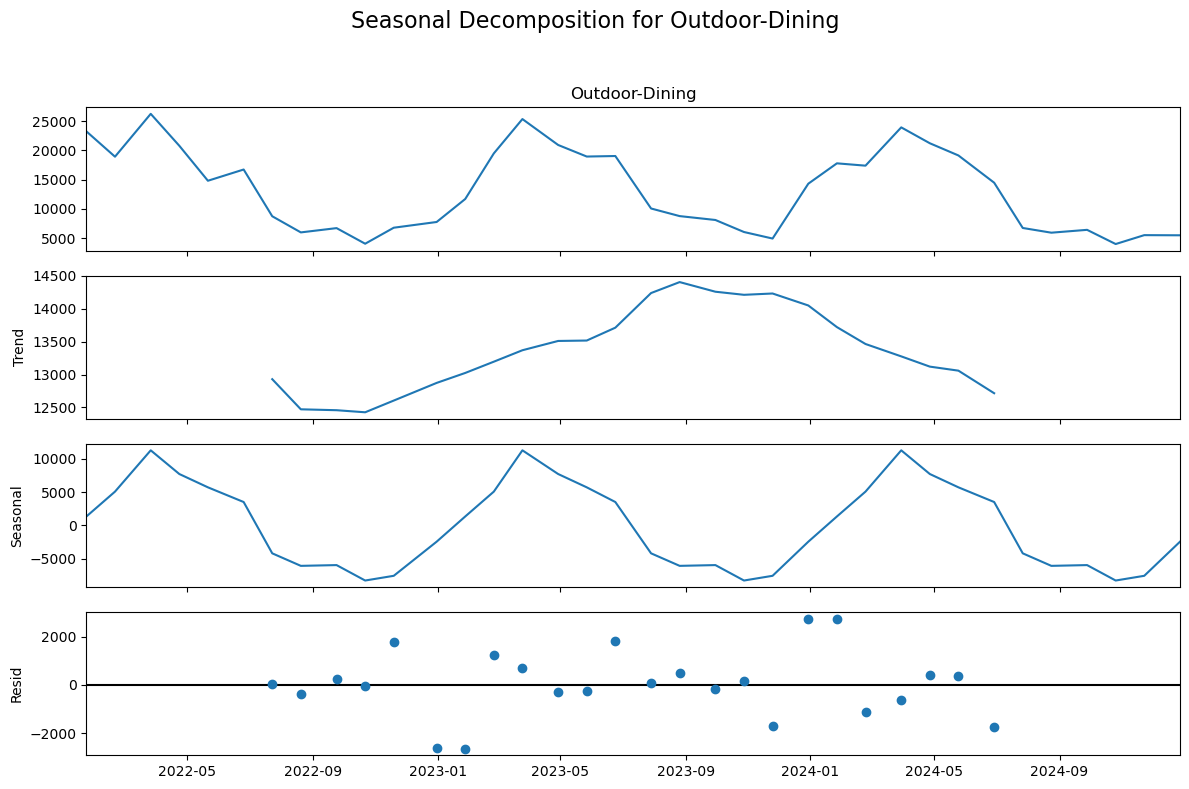

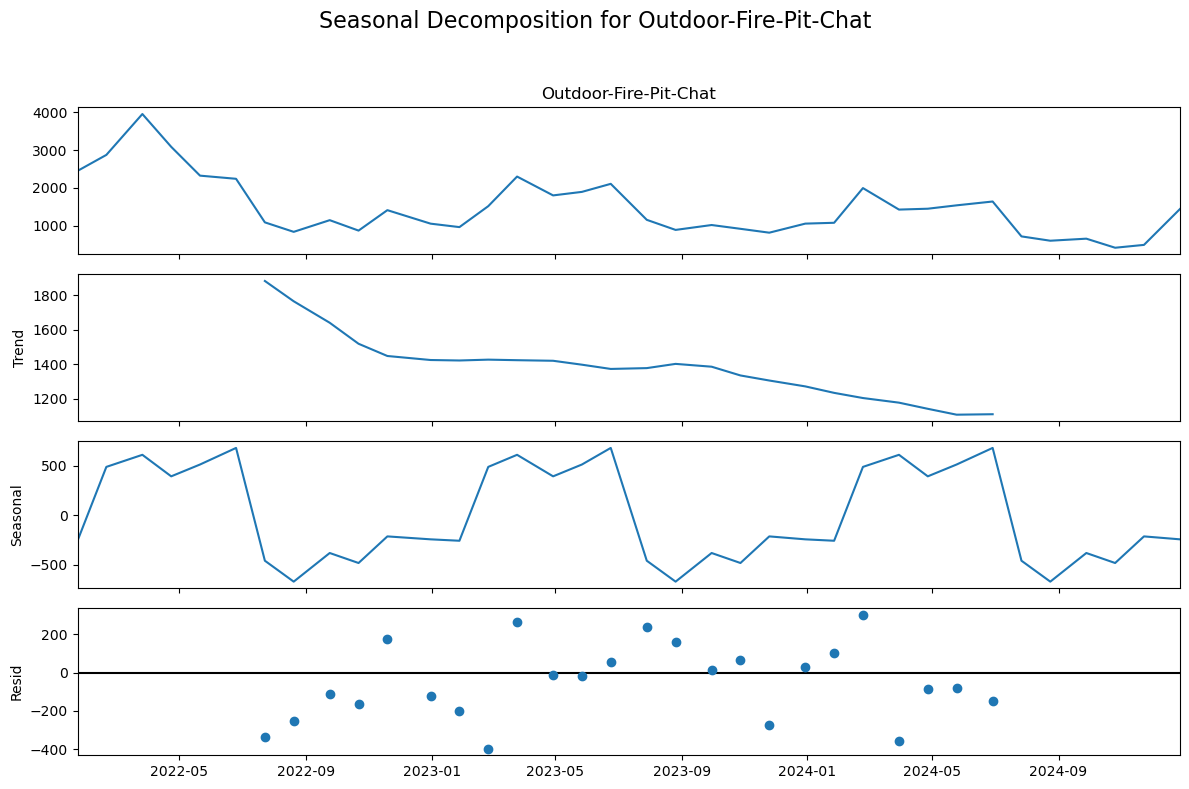

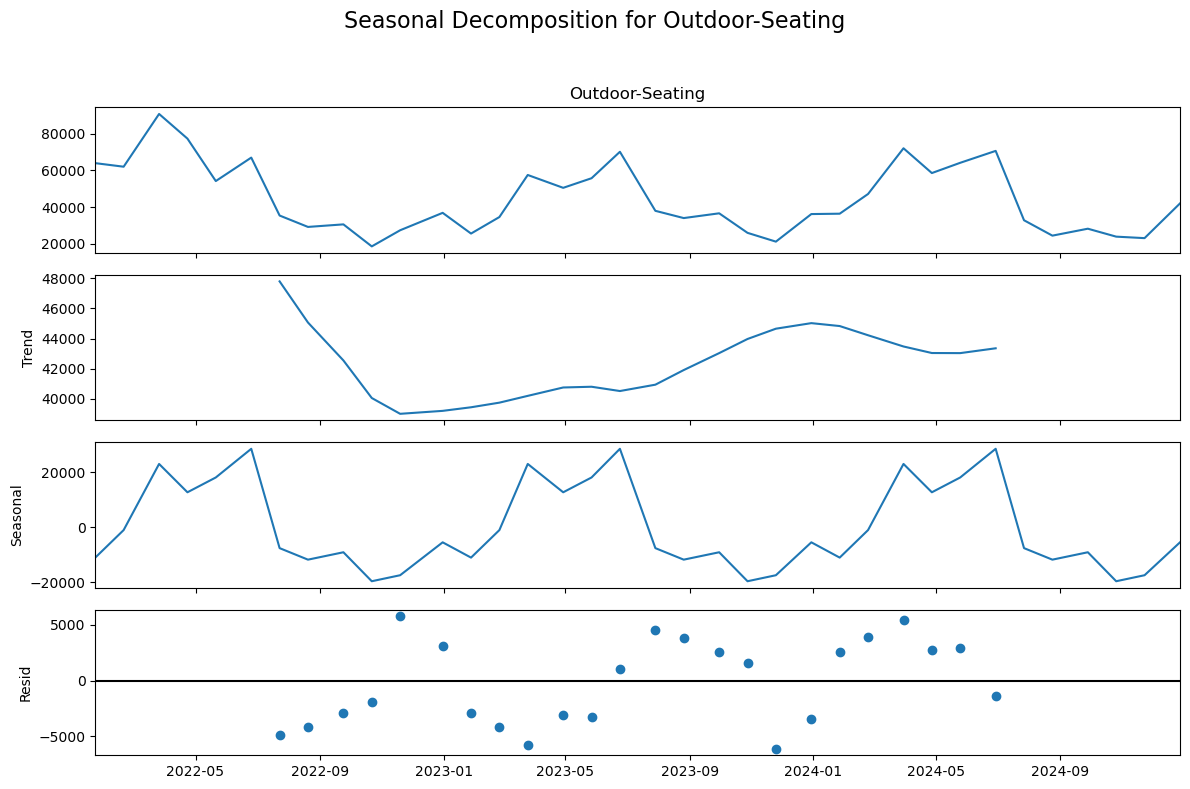

In [67]:
# (2) Decomposition for Item Grouping Level:
# Assume item grouping columns are those without an underscore and not "Total"
item_grouping_cols = [col for col in df_adj.columns if col != "Total" and "_" not in col]
print("\nDecomposition for Item Grouping Level:")
for col in item_grouping_cols:
    series = df_adj[col]
    if len(series.dropna()) < 24:
        print(f"Not enough data to decompose {col}")
        continue
    try:
        decomp = seasonal_decompose(series, model="additive", period=12)
        fig = decomp.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle(f"Seasonal Decomposition for {col}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    except Exception as e:
        print(f"Decomposition failed for {col}: {e}")

## Top producing serries and SKUs

In [68]:
import pandas as pd
import plotly.express as px

# Load the wide hierarchical data, parsing the date column
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Identify Series-level columns:
# By convention, Series-level columns have exactly one underscore (and are not "Total")
series_columns = [col for col in df.columns if col != "Total" and col.count("_") == 1]

# Compute total sales for each series over the entire period
total_sales = df[series_columns].sum()

# Select the top 10 series based on total sales
top10_series = total_sales.sort_values(ascending=False).head(5).reset_index()
top10_series.columns = ["Series", "Total_Sales"]

# Filter the DataFrame to include only FiscalMonthLastDate and the top 10 series columns
df_top10 = df[["FiscalMonthLastDate"] + top10_series["Series"].tolist()]

# Convert from wide to long format for plotting
df_long = df_top10.melt(id_vars="FiscalMonthLastDate", var_name="Series", value_name="Sales")

# Create an interactive line chart using Plotly Express
fig = px.line(
    df_long,
    x="FiscalMonthLastDate",
    y="Sales",
    color="Series",
    title="Top 5 Most Selling Series (All Time)",
    labels={"FiscalMonthLastDate": "Date", "Sales": "Total Sales"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="Total Sales")
fig.show()



#==========================================================
#Part B: sales in last 12 months

# Determine the latest date in the data and define the start of the last 12 months period
max_date = df["FiscalMonthLastDate"].max()
start_date = max_date - pd.DateOffset(months=12)

# Filter the DataFrame for the last 12 months
df_last12 = df[df["FiscalMonthLastDate"] >= start_date]

# Identify Series-level columns (exactly one underscore, excluding "Total")
series_columns = [col for col in df.columns if col != "Total" and col.count("_") == 1]

# Compute total sales for each series in the last 12 months
total_sales_last12 = df_last12[series_columns].sum()

# Select the top 10 series by sales for the last 12 months
top10_series_last12 = total_sales_last12.sort_values(ascending=False).head(5).reset_index()
top10_series_last12.columns = ["Series", "Total_Sales_Last12"]

# Filter the last 12-month DataFrame for the relevant columns
df_top10_last12 = df_last12[["FiscalMonthLastDate"] + top10_series_last12["Series"].tolist()]

# Convert from wide to long format for plotting
df_long_last12 = df_top10_last12.melt(id_vars="FiscalMonthLastDate", var_name="Series", value_name="Sales")

# Create an interactive line chart for the last 12 months using Plotly Express
fig = px.line(
    df_long_last12,
    x="FiscalMonthLastDate",
    y="Sales",
    color="Series",
    title="Top 5 Most Selling Series (Last 12 Months)",
    labels={"FiscalMonthLastDate": "Date", "Sales": "Total Sales (Last 12 Months)"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="Total Sales (Last 12 Months)")
fig.show()


In [69]:
import pandas as pd
import plotly.express as px

#Part A: The sales of all time

# Load the wide-format hierarchical data, parsing the date column.
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Identify SKU-level columns (columns with exactly two underscores)
sku_columns = [col for col in df.columns if col != "Total" and col.count("_") == 2]

# Compute total sales for each SKU over the entire time period.
total_sales = df[sku_columns].sum()

# Select the top 10 SKUs based on total sales.
top10_skus = total_sales.sort_values(ascending=False).head(5).index.tolist()

# Filter the DataFrame to include only the FiscalMonthLastDate and the top 10 SKU columns.
df_top10 = df[["FiscalMonthLastDate"] + top10_skus]

# Convert the data from wide to long format so that each SKU's time series becomes a separate line.
df_melt = df_top10.melt(id_vars="FiscalMonthLastDate", var_name="SKU", value_name="Sales")

# Create an interactive line chart using Plotly Express.
fig = px.line(
    df_melt,
    x="FiscalMonthLastDate",
    y="Sales",
    color="SKU",
    title="Top 5 Most Selling SKUs (All Time)",
    labels={"FiscalMonthLastDate": "Date", "Sales": "Total Sales"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="Total Sales")
fig.show()


#==================================================================================
#Part B: the sales last year

# Determine the latest date in the dataset and compute the start date for the last 12 months.
max_date = df["FiscalMonthLastDate"].max()
start_date = max_date - pd.DateOffset(months=12)

# Filter the DataFrame for the last 12 months.
df_last12 = df[df["FiscalMonthLastDate"] >= start_date]

# Identify SKU-level columns (columns with exactly two underscores).
sku_columns = [col for col in df.columns if col != "Total" and col.count("_") == 2]

# Compute total sales for each SKU over the last 12 months.
total_sales_last12 = df_last12[sku_columns].sum()

# Select the top 5 SKUs based on the last 12 months' sales.
top10_skus_last12 = total_sales_last12.sort_values(ascending=False).head(5).index.tolist()

# Filter the DataFrame to include only FiscalMonthLastDate and the top 10 SKU columns.
df_top10_last12 = df_last12[["FiscalMonthLastDate"] + top10_skus_last12]

# Convert from wide to long format for plotting.
df_melt_last12 = df_top10_last12.melt(id_vars="FiscalMonthLastDate", var_name="SKU", value_name="Sales")

# Create an interactive line chart for the last 12 months.
fig = px.line(
    df_melt_last12,
    x="FiscalMonthLastDate",
    y="Sales",
    color="SKU",
    title="Top 5 Most Selling SKUs (Last 12 Months)",
    labels={"FiscalMonthLastDate": "Date", "Sales": "Total Sales (Last 12 Months)"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="Total Sales (Last 12 Months)")
fig.show()

# Step 4: Model

## Exponential Smoothing

Index:
DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='FiscalMonthLastDate', freq=None)

'Total' column sample:
FiscalMonthLastDate
2022-01-31     90997
2022-02-28     84662
2022-03-31    122056
2022-04-30    102546
2022-05-31     72504
2022-06-30     87400
2022-07-31     46117
2022-08-31     36747
2022-09-30     39362
2022-10-31     24172
Name: Total, dtype: in

C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Forecast completed for Outdoor-Dining.
Forecast completed for Outdoor-Fire-Pit-Chat.
Forecast completed for Outdoor-Seating.


C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Forecast completed for Outdoor-Accessories_P000.
Forecast completed for Outdoor-Accessories_P018.
Forecast completed for Outdoor-Accessories_P030.
Forecast completed for Outdoor-Accessories_PA160.
Forecast completed for Outdoor-Accessories_PA187.
Forecast completed for Outdoor-Accessories_PA226.
Forecast completed for Outdoor-Accessories_PA273.
Forecast completed for Outdoor-Accessories_PA283.
Forecast completed for Outdoor-Accessories_PA285.
Forecast completed for Outdoor-Accessories_PA297.
Forecast completed for Outdoor-Accessories_PA30-1.
Forecast completed for Outdoor-Accessories_PA301.
Forecast completed for Outdoor-Accessories_PA302.
Forecast completed for Outdoor-Accessories_PA305.
Forecast completed for Outdoor-Accessories_PA307.
Forecast completed for Outdoor-Accessories_PA308.
Forecast completed for Outdoor-Accessories_PA309.
Forecast completed for Outdoor-Accessories_PA313.
Forecast completed for Outdoor-Accessories_PA320.
Forecast completed for Outdoor-Accessories_PA325.
Fo

C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Forecast completed for Outdoor-Dining_P421.
Forecast completed for Outdoor-Dining_P426-625.
Forecast completed for Outdoor-Dining_P439.
Forecast completed for Outdoor-Dining_P455.
Forecast completed for Outdoor-Dining_P456.
Forecast completed for Outdoor-Dining_P460.
Forecast completed for Outdoor-Dining_P518-625.
Forecast completed for Outdoor-Dining_P520.
Forecast completed for Outdoor-Dining_P564-625.
Forecast completed for Outdoor-Dining_P671-625.
Forecast completed for Outdoor-Dining_P690-625.
Forecast completed for Outdoor-Dining_P701-625.
Forecast completed for Outdoor-Dining_P730.
Forecast completed for Outdoor-Dining_P749-665.
Forecast completed for Outdoor-Dining_P750-665.
Forecast completed for Outdoor-Dining_P791-625.
Forecast completed for Outdoor-Dining_P792-625.
Forecast completed for Outdoor-Dining_P798-613.
Forecast completed for Outdoor-Dining_P798-625.
Forecast completed for Outdoor-Dining_P801.
Forecast completed for Outdoor-Dining_P802-625.
Forecast completed for O

C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Forecast completed for Outdoor-Seating_P660.
Forecast completed for Outdoor-Seating_P671.
Forecast completed for Outdoor-Seating_P690-772.
Forecast completed for Outdoor-Seating_P695.
Forecast completed for Outdoor-Seating_P701.
Forecast completed for Outdoor-Seating_P704.
Forecast completed for Outdoor-Seating_P711.
Forecast completed for Outdoor-Seating_P750.
Forecast completed for Outdoor-Seating_P783.
Forecast completed for Outdoor-Seating_P783-838.
Forecast completed for Outdoor-Seating_P784.
Forecast completed for Outdoor-Seating_P791.
Forecast completed for Outdoor-Seating_P791-825.
Forecast completed for Outdoor-Seating_P792.
Forecast completed for Outdoor-Seating_P798.
Forecast completed for Outdoor-Seating_P800.
Forecast completed for Outdoor-Seating_P801.
Forecast completed for Outdoor-Seating_P802.
Forecast completed for Outdoor-Seating_P804.
Forecast completed for Outdoor-Seating_P804-846.
Forecast completed for Outdoor-Seating_P804-854.
Forecast completed for Outdoor-Seat

Forecast completed for Outdoor-Accessories_PA451_PA451-032.
Forecast completed for Outdoor-Accessories_PA451_PA451-043.
Forecast completed for Outdoor-Accessories_PA451_PA451-053.
Forecast completed for Outdoor-Accessories_PA451_PA451-063.
Forecast completed for Outdoor-Accessories_PA451_PA451-073.
Forecast completed for Outdoor-Accessories_PA452_PA452-001.
Forecast completed for Outdoor-Accessories_PA452_PA452-011.
Forecast completed for Outdoor-Accessories_PA453_PA453-003.
Forecast completed for Outdoor-Accessories_PA453_PA453-013.
Forecast completed for Outdoor-Accessories_PA453_PA453-022.
Forecast completed for Outdoor-Accessories_PA453_PA453-023.
Forecast completed for Outdoor-Accessories_PA455_PA455-001.
Forecast completed for Outdoor-Accessories_PA455_PA455-002.
Forecast completed for Outdoor-Accessories_PA455_PA455-003.
Forecast completed for Outdoor-Accessories_PA455_PA455-011.
Forecast completed for Outdoor-Accessories_PA455_PA455-012.
Forecast completed for Outdoor-Accessori

Forecast completed for Outdoor-Accessories_PA804_PA804-011.
Forecast completed for Outdoor-Accessories_PA804_PA804-012.
Forecast completed for Outdoor-Accessories_PA804_PA804-013.
Forecast completed for Outdoor-Accessories_PA804_PA804-022.
Forecast completed for Outdoor-Accessories_PA804_PA804-023.
Forecast completed for Outdoor-Accessories_PA804_PA804-032.
Forecast completed for Outdoor-Dining_P201_P201-049.
Forecast completed for Outdoor-Dining_P201-050_P201-050.
Forecast completed for Outdoor-Dining_P207_P207-615.
Forecast completed for Outdoor-Dining_P208_P208-124.
Forecast completed for Outdoor-Dining_P208_P208-632.
Forecast completed for Outdoor-Dining_P209_P209-601A.
Forecast completed for Outdoor-Dining_P210_P210-601A.
Forecast completed for Outdoor-Dining_P210-632_P210-124.
Forecast completed for Outdoor-Dining_P210-632_P210-632.
Forecast completed for Outdoor-Dining_P210-642_P210-642.
Forecast completed for Outdoor-Dining_P211_P211-124.
Forecast completed for Outdoor-Dining_P

Forecast completed for Outdoor-Seating_P008-813_P008-813.
Forecast completed for Outdoor-Seating_P008-827_P008-827.
Forecast completed for Outdoor-Seating_P009_P009-703.
Forecast completed for Outdoor-Seating_P009_P009-898.
Forecast completed for Outdoor-Seating_P009-813_P009-813.
Forecast completed for Outdoor-Seating_P011_P011-703.
Forecast completed for Outdoor-Seating_P011_P011-898.
Forecast completed for Outdoor-Seating_P011-813_P011-813.
Forecast completed for Outdoor-Seating_P011-827_P011-827.
Forecast completed for Outdoor-Seating_P012_P012-703.
Forecast completed for Outdoor-Seating_P012_P012-898.
Forecast completed for Outdoor-Seating_P012-813_P012-813.
Forecast completed for Outdoor-Seating_P013_P013-703.
Forecast completed for Outdoor-Seating_P013_P013-813.
Forecast completed for Outdoor-Seating_P013_P013-898.
Forecast completed for Outdoor-Seating_P014_P014-703.
Forecast completed for Outdoor-Seating_P014_P014-898.
Forecast completed for Outdoor-Seating_P014-813_P014-813.


Forecast completed for Outdoor-Seating_P507_P507-835.
Forecast completed for Outdoor-Seating_P507_P507-838.
Forecast completed for Outdoor-Seating_P514_P514-701.
Forecast completed for Outdoor-Seating_P514_P514-702.
Forecast completed for Outdoor-Seating_P514_P514-820.
Forecast completed for Outdoor-Seating_P514_P514-835.
Forecast completed for Outdoor-Seating_P514_P514-838.
Forecast completed for Outdoor-Seating_P518_P518-701.
Forecast completed for Outdoor-Seating_P518_P518-702.
Forecast completed for Outdoor-Seating_P518_P518-821.
Forecast completed for Outdoor-Seating_P518_P518-835.
Forecast completed for Outdoor-Seating_P518_P518-838.
Forecast completed for Outdoor-Seating_P560_P560-701.
Forecast completed for Outdoor-Seating_P560_P560-702.
Forecast completed for Outdoor-Seating_P560_P560-821.
Forecast completed for Outdoor-Seating_P560_P560-835.
Forecast completed for Outdoor-Seating_P560_P560-838.
Forecast completed for Outdoor-Seating_P564_P564-701.
Forecast completed for Outdo

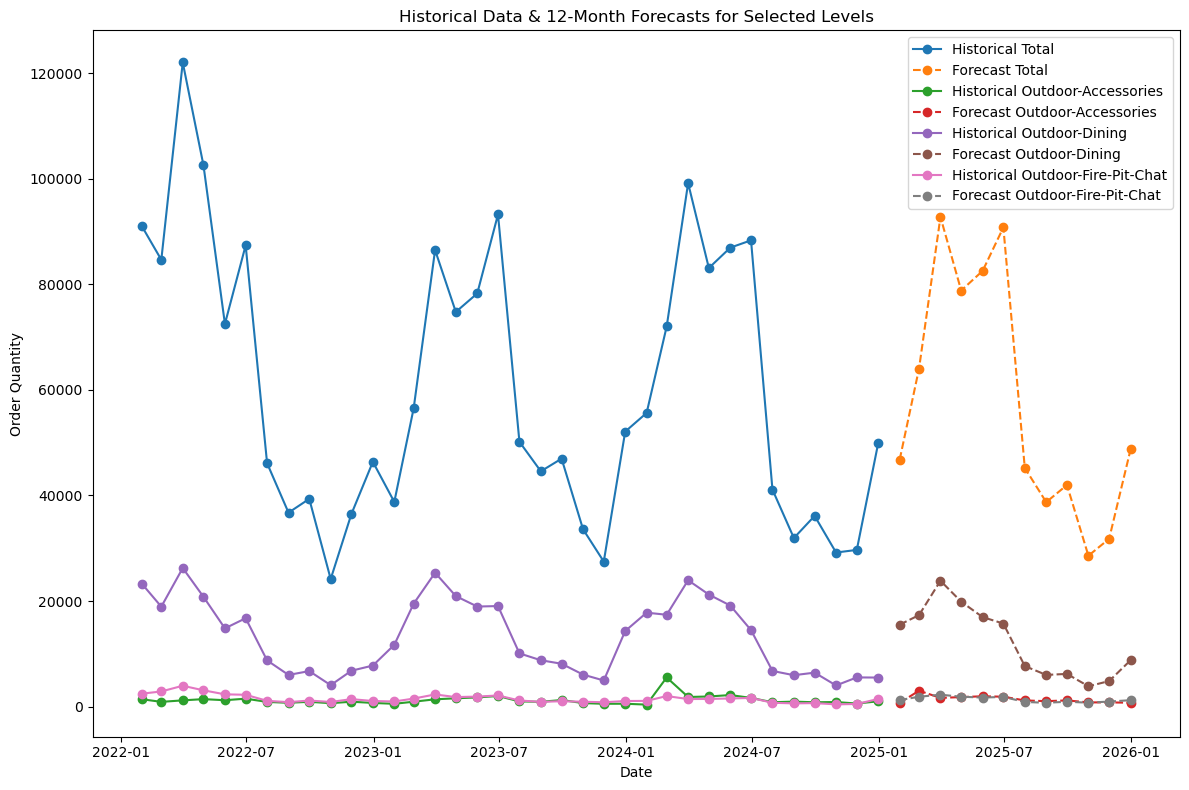

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# === Step 1: Read and Prepare the Data ===
# Read CSV and parse dates from "FiscalMonthLastDate"
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Convert the dates to month-end so that every date is standardized.
# For example, if a date is 2022-01-22, it becomes 2022-01-31.
df["FiscalMonthLastDate"] = df["FiscalMonthLastDate"].dt.to_period('M').dt.to_timestamp('M')

# Set the date as index and sort by it.
df_hier = df.set_index("FiscalMonthLastDate").sort_index()

# (Optional) Check the index to ensure it is complete and at month-end.
print("Index:")
print(df_hier.index)
print("\n'Total' column sample:")
print(df_hier["Total"].head(10))

# Force the DataFrame to have a complete monthly frequency.
df_hier = df_hier.asfreq('M')

# === Step 2: Set Up Forecasting Parameters ===
# Forecast horizon: next 12 months
forecast_horizon = 12
last_date = df_hier.index.max()
# Create a forecast index starting from the month after the last date
forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=forecast_horizon, freq='M')

# === Step 3: Forecast Each Series in the Hierarchy ===
forecast_results = {}

# Loop over every column (each hierarchical level)
for col in df_hier.columns:
    # Ensure the series is at monthly frequency
    series = df_hier[col].asfreq('M')
    
    # If there are fewer than 6 non-missing points, skip fitting and forecast zeros.
    if series.dropna().shape[0] < 6:
        forecast_results[col] = pd.Series(np.zeros(forecast_horizon), index=forecast_index)
        print(f"Not enough data for {col} (only {series.dropna().shape[0]} points); forecasting zeros.")
        continue
    
    try:
        # Fit an Exponential Smoothing model with additive seasonality (seasonal period of 12)
        model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12).fit(optimized=True)
        fc = model.forecast(forecast_horizon)
        # Assign the forecast to our forecast index
        fc = pd.Series(fc, index=forecast_index)
        forecast_results[col] = fc
        print(f"Forecast completed for {col}.")
    except Exception as e:
        print(f"Forecasting failed for {col}: {e}")
        forecast_results[col] = pd.Series(np.zeros(forecast_horizon), index=forecast_index)

# Combine all forecasts into a single DataFrame.
df_forecasts = pd.DataFrame(forecast_results, index=forecast_index)

print("\nForecasts for the Next 12 Months (All Levels):")
print(df_forecasts)

# === Step 4: (Optional) Plot a Few Example Series ===
# For example, we plot "Total" and a few additional columns.
example_cols = ['Total']
# You can adjust or add columns here as needed.
if len(df_hier.columns) > 1:
    example_cols.extend(df_hier.columns[1:4].tolist())

plt.figure(figsize=(12, 8))
for col in example_cols:
    if col in df_hier.columns:
        plt.plot(df_hier.index, df_hier[col], marker='o', label=f"Historical {col}")
        if col in df_forecasts.columns:
            plt.plot(df_forecasts.index, df_forecasts[col], marker='o', linestyle='--', label=f"Forecast {col}")
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.title("Historical Data & 12-Month Forecasts for Selected Levels")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# === Step 5: Calculate MAPE and WMAPE for Each Series (Using a 12-Month Hold-Out) ===
# Define error metric functions
def mape(actual, predicted):
    # Replace zeros in actual to avoid division by zero.
    actual_nozero = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual_nozero)) * 100

def wmape(actual, predicted):
    return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100

# Prepare a list to store the metrics for each series.
error_metrics = []

# We'll loop through each column in df_hier.
# We require at least 24 non-missing data points to have a training set and a test set.
for col in df_hier.columns:
    series = df_hier[col].dropna()
    if len(series) < 24:
        # Skip series that are too short.
        continue
    # Use the last 12 months as the test set and the rest as training.
    train = series.iloc[:-12]
    test = series.iloc[-12:]
    
    try:
        # Fit the Holt-Winters model on the training set.
        model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit(optimized=True)
        forecast_test = model.forecast(12)
        # Align forecast with the test set index.
        forecast_test = pd.Series(forecast_test, index=test.index)
        
        # Calculate error metrics.
        mape_val = mape(test.values, forecast_test.values)
        wmape_val = wmape(test.values, forecast_test.values)
        
        error_metrics.append({
            'Series': col,
            'MAPE (%)': mape_val,
            'WMAPE (%)': wmape_val,
            'Train Length': len(train),
            'Test Length': len(test)
        })
    except Exception as e:
        print(f"Error forecasting {col}: {e}")

# Convert the error metrics list into a DataFrame for easier inspection.
error_df = pd.DataFrame(error_metrics)

# Sort by MAPE (or any other metric) to see which series forecast best.
error_df = error_df.sort_values('MAPE (%)')
print("\nError Metrics (MAPE and WMAPE) for Series with Enough Data:")
print(error_df)

# --- Optional: If you're particularly interested in the 'Total' series, display its metrics separately ---
if 'Total' in error_df['Series'].values:
    total_metrics = error_df[error_df['Series'] == 'Total']
    print("\nError Metrics for 'Total' Series:")
    print(total_metrics)


C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\1544309526.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1411: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: 


Error Metrics (MAPE and WMAPE) for Series with Enough Data:
                            Series      MAPE (%)    WMAPE (%)  Train Length  \
244           Outdoor-Seating_P800  8.333333e+00   100.000000            24   
922  Outdoor-Seating_P800_P800-701  8.333333e+00   100.000000            24   
923  Outdoor-Seating_P800_P800-702  8.333333e+00   100.000000            24   
924  Outdoor-Seating_P800_P800-820  8.333333e+00   100.000000            24   
925  Outdoor-Seating_P800_P800-835  8.333333e+00   100.000000            24   
..                             ...           ...          ...           ...   
215           Outdoor-Seating_P440  1.709924e+20   893.484654            24   
736  Outdoor-Seating_P350_P350-035  1.953521e+20   821.124053            24   
120            Outdoor-Dining_P421  2.206742e+20   112.018986            24   
737  Outdoor-Seating_P350_P350-820  4.817326e+20  4459.836753            24   
202           Outdoor-Seating_P350  1.019170e+21  3486.567654         

In [28]:
# Assume error_df exists from the previous forecasting error calculations.
# For example, error_df might have columns: 'Series', 'MAPE (%)', 'WMAPE (%)', 'Train Length', 'Test Length'.

# Create a copy and round the metrics for clarity.
error_df_formatted = error_df.copy()
error_df_formatted['MAPE (%)'] = error_df_formatted['MAPE (%)'].round(2)
error_df_formatted['WMAPE (%)'] = error_df_formatted['WMAPE (%)'].round(2)

# Define a custom sort key function for hierarchical sorting.
def sort_key(series_name):
    # "Total" should come first.
    if series_name == "Total":
        return (0, series_name)
    # Count underscores:
    underscore_count = series_name.count("_")
    # No underscores: assume item level.
    if underscore_count == 0:
        return (1, series_name)
    # One underscore: series level.
    elif underscore_count == 1:
        return (2, series_name)
    # Two or more underscores: SKU level.
    else:
        return (3, series_name)

# Add a temporary 'SortKey' column.
error_df_formatted["SortKey"] = error_df_formatted["Series"].apply(sort_key)

# Sort the DataFrame by this new column.
error_df_sorted = error_df_formatted.sort_values(by="SortKey").drop(columns=["SortKey"])

# Optionally, you can also re-order columns if you want.
# For example, you might want the columns in the order: Series, Train Length, Test Length, MAPE (%), WMAPE (%)
error_df_sorted = error_df_sorted[['Series', 'Train Length', 'Test Length', 'MAPE (%)', 'WMAPE (%)']]

# Export the sorted error metrics to CSV.
error_df_sorted.to_csv("error_metrics_sorted.csv", index=False)

print("Sorted error metrics exported to 'error_metrics_sorted.csv'")


Sorted error metrics exported to 'error_metrics_sorted.csv'


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- 1. Load the Hierarchical Data ---
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Convert each date to month-end to align with a monthly frequency
df["FiscalMonthLastDate"] = df["FiscalMonthLastDate"].dt.to_period('M').dt.to_timestamp('M')

# Set the date as index, sort by it, and force monthly frequency
df_hier = df.set_index("FiscalMonthLastDate").sort_index()
df_hier = df_hier.asfreq('M')

# --- 2. Define Error Metric Functions ---
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

def mape(actual, predicted):
    # Replace zeros in actual to avoid division by zero
    actual_nozero = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual_nozero)) * 100

def wmape(actual, predicted):
    return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100

# We'll store error metrics in 'results' and next-12-month forecasts in 'forecasts_12'
results = []
forecasts_12 = {}

# --- 3. Loop Over Each Series in the Hierarchy ---
for col in df_hier.columns:
    # Drop NaNs so we have a clean series
    series = df_hier[col].dropna()
    
    # Require at least 24 points (12 for training + 12 for testing)
    if len(series) < 24:
        continue
    
    # Split: last 12 months = test, the rest = train
    train = series.iloc[:-12]
    test = series.iloc[-12:]
    
    try:
        # --- 4. Fit Model on Training Set ---
        model = ExponentialSmoothing(
            train,
            seasonal='add',
            seasonal_periods=12
        ).fit(optimized=True)
        
        # --- 5. Forecast on Test Set ---
        forecast_test = model.forecast(12)
        # Align the forecast index with the test index
        forecast_test = forecast_test.reindex(test.index)
        
        # --- 6. Compute Error Metrics ---
        mse_val = mse(test.values, forecast_test.values)
        rmse_val = rmse(test.values, forecast_test.values)
        mape_val = mape(test.values, forecast_test.values)
        wmape_val = wmape(test.values, forecast_test.values)
        
        # --- 7. Re-fit on Full Series and Forecast Next 12 Months ---
        final_model = ExponentialSmoothing(
            series,
            seasonal='add',
            seasonal_periods=12
        ).fit(optimized=True)
        
        last_date = series.index.max()
        forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')
        
        forecast_future = final_model.forecast(12)
        forecast_future = pd.Series(forecast_future, index=forecast_index)
        
        # Store the next-12-month forecast in a dictionary
        forecasts_12[col] = forecast_future
        
        # --- Store metrics in a list for eventual DataFrame ---
        results.append({
            "Series": col,
            "Train Length": len(train),
            "Test Length": len(test),
            "MSE": mse_val,
            "RMSE": rmse_val,
            "MAPE": mape_val,
            "WMAPE": wmape_val
        })
        
    except Exception as e:
        print(f"Error processing {col}: {e}")
        continue

# --- 8. Create a DataFrame of Error Metrics and Export ---
df_results = pd.DataFrame(results)

# Round for clarity
df_results["MSE"] = df_results["MSE"].round(2)
df_results["RMSE"] = df_results["RMSE"].round(2)
df_results["MAPE"] = df_results["MAPE"].round(2)
df_results["WMAPE"] = df_results["WMAPE"].round(2)

# Sort by MAPE ascending
df_results = df_results.sort_values("MAPE")

# Display the first 10 rows of metrics
print("\nError Metrics (MSE, RMSE, MAPE, WMAPE) for Each Series:")
print(df_results.head(10))

# Optionally export the metrics to CSV
df_results.to_csv("Forecast_Error_Metrics.csv", index=False)

# --- 9. Combine the Next-12-Month Forecasts into One DataFrame ---
df_forecast_12 = pd.DataFrame(forecasts_12)
print("\nNext 12-Month Forecasts (first 5 rows shown):")
print(df_forecast_12.head())

# Optionally export the 12-month forecasts to CSV
df_forecast_12.to_csv("Forecasts_Next_12_Months.csv", index=True)


C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge


Error Metrics (MSE, RMSE, MAPE, WMAPE) for Each Series:
                                  Series  Train Length  Test Length      MSE  \
244                 Outdoor-Seating_P800            24           12  7203.00   
922        Outdoor-Seating_P800_P800-701            24           12   290.08   
923        Outdoor-Seating_P800_P800-702            24           12   290.08   
924        Outdoor-Seating_P800_P800-820            24           12  1140.75   
925        Outdoor-Seating_P800_P800-835            24           12   290.08   
492  Outdoor-Accessories_PA792_PA792-042            24           12     1.33   
491  Outdoor-Accessories_PA792_PA792-032            24           12     0.33   
11             Outdoor-Accessories_PA273            24           12  1064.08   
490  Outdoor-Accessories_PA792_PA792-023            24           12     1.33   
179                 Outdoor-Seating_P273            24           12  4524.08   

      RMSE  MAPE  WMAPE  
244  84.87  8.33  100.0  
922  17.03

## Sarima

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# --- Step 1: Load and Prepare the Data ---
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])

# Convert to month-end for consistency
df["FiscalMonthLastDate"] = df["FiscalMonthLastDate"].dt.to_period('M').dt.to_timestamp('M')

# Set index, sort, and enforce monthly frequency
df_hier = df.set_index("FiscalMonthLastDate").sort_index()
df_hier = df_hier.asfreq('M')

# --- Define Error Metrics ---
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

def mape(actual, predicted):
    # Replace zeros in actual to avoid division by zero
    actual_nozero = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual_nozero)) * 100

def wmape(actual, predicted):
    return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100

# Lists to store results
results = []
forecasts_12 = {}

# --- Step 2: Loop Over Each Series ---
for col in df_hier.columns:
    series = df_hier[col].dropna()
    
    # Require at least 24 data points (12 for train + 12 for test)
    if len(series) < 24:
        continue
    
    # Split into train (all but last 12) and test (last 12)
    train = series.iloc[:-12]
    test = series.iloc[-12:]
    
    try:
        # --- Step 3: Fit an Auto ARIMA Model on the Training Set ---
        # We set seasonal=True, m=12 for monthly seasonality
        # Adjust max_p, max_q, etc., to limit search if needed
        model = auto_arima(
            train,
            start_p=0, start_q=0,
            max_p=5, max_q=5,  # limit the search space
            seasonal=True,
            m=12,  # monthly seasonality
            start_P=0, start_Q=0,
            max_P=6, max_Q=6,  # limit the seasonal search
            d=None,  # let auto_arima find differencing
            D=None,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # Create forecast for the test set horizon
        fc_test = model.predict(n_periods=12)
        # Align the forecast index with the test index
        fc_test = pd.Series(fc_test, index=test.index)
        
        # --- Step 4: Compute Error Metrics on Test Set ---
        mse_val = mse(test.values, fc_test.values)
        rmse_val = rmse(test.values, fc_test.values)
        mape_val = mape(test.values, fc_test.values)
        wmape_val = wmape(test.values, fc_test.values)
        
        # --- Step 5: Re-fit on Full Data & Forecast Next 12 Months ---
        model.update(series)  # pmdarima lets you update the existing model with new data
        # or you can re-fit from scratch:
        # model = auto_arima(series, ... same params ...)
        
        fc_future = model.predict(n_periods=12)
        last_date = series.index.max()
        forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')
        fc_future = pd.Series(fc_future, index=forecast_index)
        
        # Store the 12-month forecast
        forecasts_12[col] = fc_future
        
        # Store metrics
        results.append({
            "Series": col,
            "Train Length": len(train),
            "Test Length": len(test),
            "MSE": mse_val,
            "RMSE": rmse_val,
            "MAPE": mape_val,
            "WMAPE": wmape_val
        })
        
    except Exception as e:
        print(f"Error processing {col}: {e}")
        continue

# --- Step 6: Create DataFrame of Error Metrics, Export ---
df_results = pd.DataFrame(results)
df_results["MSE"] = df_results["MSE"].round(2)
df_results["RMSE"] = df_results["RMSE"].round(2)
df_results["MAPE"] = df_results["MAPE"].round(2)
df_results["WMAPE"] = df_results["WMAPE"].round(2)

# Sort by MAPE ascending
df_results = df_results.sort_values("MAPE")

print("\nError Metrics (MSE, RMSE, MAPE, WMAPE) for Each Series:")
print(df_results.head(10))

df_results.to_csv("ARIMA_Forecast_Error_Metrics.csv", index=False)

# --- Step 7: Combine Next-12-Month Forecasts into a Single DataFrame, Export ---
df_forecasts_12 = pd.DataFrame(forecasts_12)
print("\nNext 12-Month Forecasts (first 5 rows shown):")
print(df_forecasts_12.head())

df_forecasts_12.to_csv("ARIMA_Forecasts_Next_12_Months.csv", index=True)

Error processing Total: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Fire-Pit-Chat: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_P018: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_P030: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA187: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA226: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA285: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA297: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA301: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA302: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Acc

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA313: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA325: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA328: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA334: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA345: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA349: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA350: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA359: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA372: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA399: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA40-1: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA407: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA417: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-dif

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA455: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA459: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA460: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA505: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA507: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA514: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA518: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Acc

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA660: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA750: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Error processing Outdoor-Accessories_PA784: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA792: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA801: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA802: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA804: There are no more samples after a first-order seaso

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P201-050: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P208: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P210-642: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P211: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P212: There 

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Dining_P323: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P372: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P384: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P407: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P407-615: There are 

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P460: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P520: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P749-665: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P792-625: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P798-625: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P801: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P802-625

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Fire-Pit-Chat_P016: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Fire-Pit-Chat_P040: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Fire-Pit-Chat_P187: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Fire-Pit-Chat_P414: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P008: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P008-813: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P008-827: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P009-813: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P01

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P285: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P297: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Seating_P328: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P330: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P332: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P334: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P335: There are

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P338: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P342: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P345: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P348: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P350: There are

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P458: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P465: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P505: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P514: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P560: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P660: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Seating_P783: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P784: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P798: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P802: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P804: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P804-854: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P804-877: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) *

Error processing Outdoor-Accessories_P018_P018-991: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_P030_P030-660: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_P030_P030-661: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA187_PA187-002: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA226_PA226-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA285_PA285-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA297_PA297-023: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA301_PA301-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA301_PA301-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA301_PA301-013: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA301_PA301-023: T

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA313_PA313-002: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA313_PA313-003: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA325_PA325-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA328_PA328-012: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA334_PA334-001: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA334_PA334-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Accessories_PA349_PA349-001: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA349_PA349-012: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA349_PA349-023: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA349_PA349-032: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA349_PA349-033: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential wo

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA361_PA361-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA372_PA372-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA390_PA390-001: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA390_PA390-002: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA390_PA390-003: All lag values up to 'maxlag' produced singular matrices. Consider u

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA417_PA417-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA417_PA417-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA420_PA420-001: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA420_PA420-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential wo

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actu

Error processing Outdoor-Accessories_PA451_PA451-011: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA451_PA451-021: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\i

Error processing Outdoor-Accessories_PA453_PA453-023: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA455_PA455-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA455_PA455-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA455_PA455-013: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential wo

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA458_PA458-001: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA458_PA458-012: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA458_PA458-013: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA458_PA458-022: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential wo

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Accessories_PA505_PA505-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA507_PA507-001: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA507_PA507-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA507_PA507-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA507_PA507-011: A

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Accessories_PA660_PA660-001: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA660_PA660-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA660_PA660-003: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA660_PA660-013: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA750_PA750-001: T

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA750_PA750-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA775_PA775-001: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\ana

Error processing Outdoor-Accessories_PA783_PA783-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA783_PA783-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA784_PA784-002: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA784_PA784-003: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA784_PA784-012: All lag values up to 'maxlag' produced singular matrices. Consider u

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_PA792_PA792-002: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Accessories_PA801_PA801-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA801_PA801-003: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA801_PA801-011: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA802_PA802-002: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA802_PA802-012: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA802_PA802-022: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA802_PA802-032: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA804_PA804-002: T

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P318_P318-601A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Dining_P323_P323-601A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P323_P323-603A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P323_P323-635: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P359_P359-615: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processi

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P421_P421-625: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Dining_P439_P439-600: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P460_P460-601A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Dining_P520_P520-130: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P564-625_P564-600: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Dining_P730_P730-601A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P730_P730-615: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P749-665_P749-130: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P749-665_P749-665: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error p

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Dining_P798-625_P798-601A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P798-625_P798-602A: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P798-625_P798-625: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining_P801_P801-130: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Er

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Fire-Pit-Chat_P414_P414-821: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is compl

Error processing Outdoor-Fire-Pit-Chat_P791_P791-773: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P008_P008-703: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P008_P008-898: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P008-813_P008-813: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Er

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Seating_P285_P285-815: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P297_P297-070: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Seating_P328_P328-080: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P330_P330-080: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P332_P332-081: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P334_P334-081: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P335_P335-081: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P338_P338-080: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P340_P340-702: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P340_P340-820: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Seating_P363_P363-701: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P363_P363-820: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P363_P363-835: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P390_P390-700: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\2318659413.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Seating_P414_P414-820: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P414_P414-835: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P414_P414-838: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P417_P417-835: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P439_P439-702: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P455_P455-625: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P458_P458-814: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P458_P458-846: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P505_P505-706: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P505_P505-821: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P507_P507-706: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P507_P507-720: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Seating_P660_P660-814: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P660_P660-846: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P660_P660-875: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P660_P660-876: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 

Error processing Outdoor-Seating_P783_P783-702: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P783-838_P783-835: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P784_P784-814: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P784_P784-815: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error pr

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P791_P791-854: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P792_P792-701: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P792_P792-838: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P798_P798-701: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P798_P798-702: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P798_P798-814: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Seating_P801_P801-820: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P802_P802-701: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P802_P802-702: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Seating_P802_P802-815: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error proces

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '



Error Metrics (MSE, RMSE, MAPE, WMAPE) for Each Series:
                                  Series  Train Length  Test Length  MSE  \
180  Outdoor-Accessories_PA360_PA360-001            24           12  0.0   
200  Outdoor-Accessories_PA451_PA451-043            24           12  0.0   
199  Outdoor-Accessories_PA451_PA451-032            24           12  0.0   
197  Outdoor-Accessories_PA443_PA443-001            24           12  0.0   
195  Outdoor-Accessories_PA440_PA440-013            24           12  0.0   
35             Outdoor-Accessories_PA645            24           12  0.0   
36             Outdoor-Accessories_PA764            24           12  0.0   
246  Outdoor-Accessories_PA782_PA782-011            24           12  0.0   
98                  Outdoor-Seating_P302            24           12  0.0   
384        Outdoor-Seating_P299_P299-070            24           12  0.0   

     RMSE  MAPE  WMAPE  
180   0.0   0.0    NaN  
200   0.0   0.0    NaN  
199   0.0   0.0    NaN  
197   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# ----------------------------
# Step 1: Load and Prepare Data
# ----------------------------
df = pd.read_csv("Ashley_Outdoor_Hierarchical.csv", parse_dates=["FiscalMonthLastDate"])
# Convert dates to month‑end (so that, for example, "2022-01-22" becomes "2022-01-31")
df["FiscalMonthLastDate"] = df["FiscalMonthLastDate"].dt.to_period('M').dt.to_timestamp('M')
# Set index and enforce monthly frequency
df_hier = df.set_index("FiscalMonthLastDate").sort_index()
df_hier = df_hier.asfreq('M')

# ----------------------------
# Step 2: Define Error Metric Functions
# ----------------------------
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

def mape(actual, predicted):
    # Avoid division by zero by replacing zero actuals with a tiny number
    actual_nozero = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual_nozero)) * 100

def wmape(actual, predicted):
    return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100

# ----------------------------
# Step 3: Define a Fine-Tuning Function for ARIMA
# ----------------------------
def tune_arima(series, seasonal_periods=12):
    """
    Tune an ARIMA model on the given series using auto_arima with
    stepwise=False (more exhaustive search). Returns the fitted model.
    """
    model = auto_arima(
        series,
        seasonal=True,
        m=seasonal_periods,
        start_p=0, start_q=0,
        max_p=5, max_q=5,            # adjust these as needed
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,            # seasonal orders (try to keep these small)
        d=None, D=None,              # let auto_arima decide differencing
        trace=True,                  # print search details
        error_action='ignore',
        suppress_warnings=True,
        stepwise=False              # exhaustive search for better tuning
    )
    return model

# ----------------------------
# Step 4: Loop Over Each Series, Tune Model, Evaluate, and Forecast
# ----------------------------
results = []      # To store error metrics for each series
forecasts_12 = {} # To store next-12-month forecasts for each series

for col in df_hier.columns:
    # Get the series and drop missing values
    series = df_hier[col].dropna()
    
    # Only proceed if there are at least 24 data points (to allow 12 for train and 12 for test)
    if len(series) < 24:
        continue

    # Split into training (all but last 12 months) and test (last 12 months)
    train = series.iloc[:-12]
    test = series.iloc[-12:]
    
    try:
        # Fine-tune ARIMA on the training set using our custom function.
        # (This may take some time if the search space is large.)
        tuned_model = tune_arima(train, seasonal_periods=12)
        
        # Print model summary for reference (optional)
        # print(f"Model for {col}:")
        # print(tuned_model.summary())
        
        # Forecast the test set horizon (12 months)
        fc_test = tuned_model.predict(n_periods=12)
        fc_test = pd.Series(fc_test, index=test.index)
        
        # Compute error metrics on the test set
        mse_val = mse(test.values, fc_test.values)
        rmse_val = rmse(test.values, fc_test.values)
        mape_val = mape(test.values, fc_test.values)
        wmape_val = wmape(test.values, fc_test.values)
        
        # Now update (or re-fit) the model on the entire series and forecast the next 12 months.
        # You can update the existing model:
        tuned_model.update(series)
        # Or re-run the tuning on the full series:
        # tuned_model = tune_arima(series, seasonal_periods=12)
        
        fc_future = tuned_model.predict(n_periods=12)
        last_date = series.index.max()
        forecast_index = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')
        fc_future = pd.Series(fc_future, index=forecast_index)
        
        # Store the future forecast in the dictionary
        forecasts_12[col] = fc_future
        
        # Append the metrics for this series
        results.append({
            "Series": col,
            "Train Length": len(train),
            "Test Length": len(test),
            "MSE": mse_val,
            "RMSE": rmse_val,
            "MAPE": mape_val,
            "WMAPE": wmape_val,
            "ARIMA Order": tuned_model.order,
            "Seasonal Order": tuned_model.seasonal_order
        })
        
    except Exception as e:
        print(f"Error processing {col}: {e}")
        continue

# ----------------------------
# Step 5: Create DataFrame of Error Metrics and Export to CSV
# ----------------------------
df_results = pd.DataFrame(results)
df_results["MSE"] = df_results["MSE"].round(2)
df_results["RMSE"] = df_results["RMSE"].round(2)
df_results["MAPE"] = df_results["MAPE"].round(2)
df_results["WMAPE"] = df_results["WMAPE"].round(2)

# Sort by MAPE (ascending)
df_results = df_results.sort_values("MAPE")
print("\nError Metrics (MSE, RMSE, MAPE, WMAPE) for Each Series (Tuned ARIMA):")
print(df_results.head(10))

# Export error metrics to CSV
df_results.to_csv("Tuned_ARIMA_Forecast_Error_Metrics.csv", index=False)

# ----------------------------
# Step 6: Combine Next-12-Month Forecasts and Export to CSV
# ----------------------------
df_forecasts_12 = pd.DataFrame(forecasts_12)
print("\nNext 12-Month Forecasts (first 5 rows):")
print(df_forecasts_12.head())

df_forecasts_12.to_csv("Tuned_ARIMA_Forecasts_Next_12_Months.csv", index=True)

# ----------------------------
# Optional: Plot a Few Example Series
# ----------------------------
example_cols = ['Total']  # change or extend as desired
for col in example_cols:
    if col in df_hier.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(df_hier.index, df_hier[col], marker='o', label="Historical")
        if col in df_forecasts_12.columns:
            plt.plot(df_forecasts_12.index, df_forecasts_12[col], marker='o', linestyle='--', label="Forecast")
        plt.title(f"Historical and Next 12-Month Forecast for {col}")
        plt.xlabel("Date")
        plt.ylabel("Order Quantity")
        plt.legend()
        plt.tight_layout()
        plt.show()


Error processing Total: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Dining: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Fire-Pit-Chat: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=544.901, Time=0.02 sec
 AR

C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=135.228, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=137.053, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=139.053, Time=0.15 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=137.053, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=139.053, Time=0.12 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=141.053, Time=0.20 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=139.053, Time=0.15 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=141.053, Time=0.22 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=143.053, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Error processing Outdoor-Accessories_P018: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_P030: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-506.511, Time=0.05 sec
Total fit time: 0.049 seconds
Error processing Outdoor-Accessories_PA187: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
Error processing Outdoor-Accessories_PA226: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.


C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-506.511, Time=0.06 sec
Total fit time: 0.063 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-506.511, Time=0.06 sec
Total fit time: 0.063 seconds
Error processing Outdoor-Accessories_PA285: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
Error processing Outdoor-Accessories_PA297: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=138.138, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=137.509, Time=0.10 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=139.509, Time=0.19 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=137.509, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=139.509, Time=0

 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=145.081, Time=0.29 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=142.693, Time=0.10 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=144.204, Time=0.18 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=144.185, Time=0.18 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=145.703, Time=1.08 sec
 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=147.706, Time=1.16 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=144.693, Time=0.13 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=146.165, Time=0.22 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   :

 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=144.273, Time=1.54 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=0.81 sec
 ARI

 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=77.699, Time=0.29 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=77.700, Time=0.33 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=79.694, Time=0.87 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=79.576, Time=1.60 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=74.830, Time=0.09 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=76.694, Time=0.17 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=76.703, Time=0.19 sec
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=76.799

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=131.858, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=133.704, Time=0.09 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=135.704, Time=0.15 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=133.704, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=135.704, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=137.704, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=135.704, Time=0.14 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=137.704, Time=0.20 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=139.704, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=118.224, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=120.193, Time=0.12 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=120.193, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=122.193, Time=0.19 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,1)(2,0,

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


Error processing Outdoor-Accessories_PA328: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=80.819, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=82.796, Time=0.07 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=84.796, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=82.796, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=84.796, Time=0.12 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=86.796, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=84.796, Time=0.11 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=86.796, Time=0.17 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=88.796, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=82.766, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=84.738, Time=0.09 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=84.7

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-506.511, Time=0.07 sec
Total fit time: 0.071 seconds
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=62.127, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=63.402, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=65.402, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=63.402, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=65.402, Time=0.10 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=67.402, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=65.402, Time=0.13 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=67.402, Time=0.18 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=69.402, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=61.716, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=63.681, Time=0.14 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=63.680, Time=0.17 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=65.672, Time=0.79 s

C:\Users\Acer\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-506.511, Time=0.07 sec
Total fit time: 0.068 seconds
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=186.678, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=188.457, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=190.457, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=188.457, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=190.457, Time=0.16 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=192.457, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=190.457, Time=0.20 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=192.457, Time=0.24 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=194.457, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=188.663, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=190.431, Time=0.15 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=192.430, Time=0.92 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=190.431, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=192

 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=124.806, Time=1.11 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=120.695, Time=0.09 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=122.534, Time=0.14 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=122.536, Time=0.16 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=124.284, Time=1.11 sec
 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=126.288, Time=1.27 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=122.137, Time=0.10 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=123.992, Time=0.15 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=123.991, Time=0.17 sec
 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,3)(2,0,0)[12] intercept

 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=56.584, Time=1.14 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIM

 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=187.373, Time=0.42 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=187.395, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=185.439, Time=0.54 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=187.395, Time=0.88 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=187.402, Time=0.95 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=187.359, Time=0.64 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=183.405, Time=0.13 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=185.362, Time=0.22 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=185.362, Time=0.27 sec
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=187.362, Time=0.28 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(3,0,2)(0,0,0)[12] inter

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=190.434, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=189.375, Time=0.14 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=191.375, Time=0.21 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=189.375, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=191.375, Time=0.19 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=193.375, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=191.375, Time=0.31 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=193.375, Time=0.38 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=195.375, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=186.831, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=185.706, Time=0.24 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=185.777, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,1)(2,0,0)[1

 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,4)(0,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,4)(1,0,0)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,5)(0,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=78.832, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=80.699, Time=0.09 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=80.700, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=84.644, Time=1.27 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=80.158, Time=0.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=82.107, Time=0.18 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time

 ARIMA(1,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,1,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=89.356, Time=0.09 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=91.321, Time=0.15 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=93.300, Time=0.44 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=91.322, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=95.300, Time=0.50 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=93.300, Time=0.53 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=95.300, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=inf, T

 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=190.352, Time=0.28 sec
 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=192.265, Time=0.90 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,0,0)(0,0,0)[12] intercept   : AIC=189.796, Time=0.17 sec
 ARIMA(4,0,0)(0,0,1)[12] intercept   : AIC=191.751, Time=0.33 sec
 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=191.748, Time=0.37 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(5,0,0)(0,0,0)[12] intercept   : AIC=191.495, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 63.710 seconds
Error processing Outdoor-Accessories_PA417: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seas

 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=91.245, Time=0.15 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=93.245, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=87.224, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=89.123, Time=0.09 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=89.123, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=91.123, Time=0.14 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=91.110, Time=0.92 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=93.110, Time=1.13 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=85.327, Time=0.30 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=87.307, Time=0.48 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=87.307, Time=0.51 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100
C:\Users\Acer\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=74.899, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=76.830, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=78.830, Time=0.12 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=76.830, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=78.830, Time=0.10 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=80.830, Time=0.16 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=78.830, Time=0.12 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=80.830, Time=0.16 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=82.830, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=74.221, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=76.198, Time=0.38 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=78.149, Time=1.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=76.198, Time=0.41 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=78.198, Time=0.54 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=80.148, Time=1.37 sec
 ARIMA(0,0,1)(2,0,0)[12] 

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=154.329, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=156.024, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=158.024, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=156.024, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=158.024, Time=0.14 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=160.024, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=158.024, Time=0.14 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=160.024, Time=0.21 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=162.024, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=155.842, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=157.752, Time=0.13 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=157.751, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=159.751, Time=0.15 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,1)(2,0,

 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=133.348, Time=0.52 sec
 ARIMA(0,0,4)(0,0,1)[12] intercept   : AIC=135.371, Time=0.93 sec
 ARIMA(0,0,4)(1,0,0)[12] intercept   : AIC=135.364, Time=0.89 sec
 ARIMA(0,0,5)(0,0,0)[12] intercept   : AIC=135.204, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=141.312, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=143.171, Time=0.12 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=143.171, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=145.171, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=147.145, Time=1.22 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=142.105, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[12] inter

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=123.700, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=125.166, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=127.166, Time=0.11 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=125.166, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=127.166, Time=0.10 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=129.166, Time=0.17 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=127.166, Time=0.16 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=129.166, Time=0.18 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=131.166, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=125.393, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=126.657, Time=0.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=126.662, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,1)(2,0,0)[1

C:\Users\Acer\AppData\Local\Temp\ipykernel_17936\3851415795.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(np.abs(actual - predicted)) / np.sum(actual) * 100


 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=109.750, Time=0.11 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=107.750, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=109.750, Time=0.10 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=111.750, Time=0.17 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=109.750, Time=0.13 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=111.750, Time=0.14 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=113.750, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=107.611, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=109.474, Time=0.10 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=109.474, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=111.435, Time=0.93 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=113.435, Time=1.17 sec
 ARIMA(0,0,1)(2,0,2)[1

Gợi ý là đang có 1 list attribute sẽ có df.columns. cho 1 user input cho tên của 1 series, sau đó sẽ sort trong df.columns để hiện ra tụi serries và sku chứa nó sau đó hiện ra và cho input 1 lần nữa